# STEM EDS element quantification and signal clustering

Investigating and segmenting phases based on their chemical fingerprints in e.g. scanning transmission electron microscopy (STEM) energy dispersive spectroscopy (EDS) can provide valuable information. Based on the investigations in [Sørhaug et al., Materials & Design, 2024](https://doi.org/10.1016/j.matdes.2024.112867) on aluminium-copper (Al, Cu) joints, the current notebook will reproduce the main results where intermetallic phase layers are identified using k-means++. (Figure 1.)

# Author 
* 2024.05.30 Jørgen A. Sørhaug - Developed EDS analysis of intermetallic phase layers in Al-Cu weld. 

# Requirements
* hyperspy version 1.7.6
* or exspy version 0.2 (and hyperspy version >= 2.0) and scikit-learn version 1.5.0

# Contents
1. [Specimen and data](#one)
2. [Loading and viewing](#two)
3. [Navigation binning and signal cropping](#three)
4. [Model fitting and element quantification](#four)
5. [Clustering intermetallic phase layers](#five)

# <a id='one'></a> 1. Specimen and data

The Al-Cu specimen and data are described in [Sørhaug, J. A. et al., Materials & Design, 2024](https://doi.org/10.1016/j.matdes.2024.112867). The specimen has been made by focused ion beam (FIB) lift-out, taken from the bimetallic weld interface. A platinum (Pt) precursor gas was deposited as protection prior to specimen lift-out and relocation to a Mo FIB-TEM grid. The ion source is gallium (Ga). Ga degenerate aluminium by infiltrating grain boundaries. High concentrations of Ga should therefore surround Al grain boundaries. 

Al-Cu intermetallic phases (IMPs) are investigated using STEM-EDS (JEOL JEM-ARM200CF integrated with CEOS spherical aberration correctors in probe and image forming optics). Since the Al is a 6xxx alloy with high concentrations of Si and Mg, we will investigate whether alloying elements can be found in the intermetallic layers. 

![alt text](ga.png)

Figure 1: (a) Bright-field STEM image of the Al-Cu weld interface, revealing nano-sized intermetallic phases at the interface. (b) High-angle annular dark field STEM image. The objective here is to segment the four layers (Al, Al-rich IMP layer, Cu-rich IMP layer, and Cu) so that we can extract chemical information from layers of interest. (c) Summed EDS spectra from the Al-rich and Cu-rich IMPs. Si and Mg are found embedded in the Al-rich IMP layer.

# <a id='two'></a> 2. Loading and viewing
The data is available from [Zenodo repository](https://doi.org/10.5281/zenodo.10478342). This notebook uses the dataset found in the zipped folder named AW.

Import libraries:

In [1]:
%matplotlib inline
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt

Check out working directory and change path accordingly:

In [2]:
import os
os.getcwd()

'/media/jorgeas/T7/Scripting/Tutorials/STEM_EDS'

Load HAADF STEM image and EDS spectrum. (Acquired synchronously.) The HAADF STEM image is identical to Figure 1 (b).

In [3]:
path = ''
haadf_fn = 'HAADF.dm3'
filename = 'EDSmap.dm3'


haadf = hs.load(path + haadf_fn) 
s = hs.load(path + filename)

WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, fal

Plot HAADF STEM image. The Al alloy is on the top, which is why we see particles dispersed. Pure Cu is at the bottom. Intermetallic phase layers are found in between.

In [ ]:
haadf.plot()

Check if the metadata is imported correctly:

In [ ]:
s.metadata

Check axes and data type:

In [ ]:
s.axes_manager

In [ ]:
s.data.dtype

Plot spectrum for signal inspection.

In [ ]:
s.plot()

It can be seen that a single spectrum has very high counts (1391,195). The reason is unknown, but is likely caused by a Software lag causing the probe to be stationary for some time. The EDS detector was still operating. This will, however, not influence the final results:

In [ ]:
s.inav[1391, 195].plot()

Plot sum spectrum.

In [ ]:
s_sum = s.sum()
s_sum.plot()

Add elements to the signal: parent materials, alloy elements, contaminants (oxides, hydrocarbons, Ar from plasma cleaning) and elements stemming from the environment (FIB-TEM grid, Pt protection layer, TEM column).

In [4]:
main_Elements = ['Al','Cu']

minor_Elements = ['Si','Mg','Mn','Fe','Cr','Zr','Ti','C','O','Ga','Ar']#,'B']

environment_Elements = ['Mo','Co'] 

elements = main_Elements + minor_Elements + environment_Elements

Set the elements to the sum signal metadata, add lines, and plot.

In [ ]:
s_sum.set_elements(elements)
s_sum.add_lines()

s_sum.plot(xray_lines = 'from_elements')

Investigate non-identified peaks.

In [ ]:
observed_uncharacterised_peak = 9.4 # keV; 
width = 0.1

# Depending on the hyperspy version:
try: from exspy.misc.eds.utils import get_xray_lines_near_energy
except ModuleError: from hs.eds import get_xray_lines_near_energy 
    
print('E =', str(observed_uncharacterised_peak), "\u00B1", width, 'keV may be ' + 
      str(get_xray_lines_near_energy(energy = (observed_uncharacterised_peak), width = width)))

We see that Pt can explain the small peak, as Pt percursor gas was used to make a protection layer during specimen preparation. We don't expect Pt in the region of interest (it is several $\mu m$ away), but Pt X-rays are emitted as scattered electrons or X-rays from elsewhere hit the protection layer. 

Add Pt to the element list.

In [ ]:
elements.append('Pt')

Re-plot the sum spectrum.

In [ ]:
s_sum.set_elements(elements)
s_sum.add_lines()
s_sum.plot(xray_lines = 'from_elements')

Add elements of interest to the signal metadata. Pt will not be included as it is not part of the scanned ROI.

In [13]:
# Ignoring environment elements from the e.g. the microscope etc.
elements = main_Elements + minor_Elements

s.set_elements(elements)
s.add_lines()

Investigating the spatial distribution of elements can provide valuable information.

In [ ]:
s.T.plot()

# <a id='three'></a> 3. Navigation binning and signal cropping
Because of the low number of counts in each pixel, the navigation axis will be binned to enhance the signal-to-noise ratio. We also crop the siganl to exclude energy ranges of no interest. This can benefit the model fitting later.

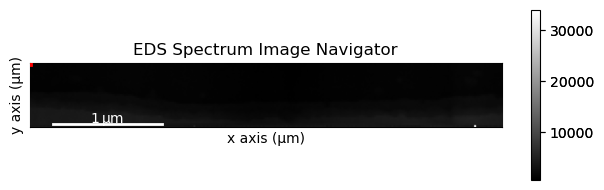

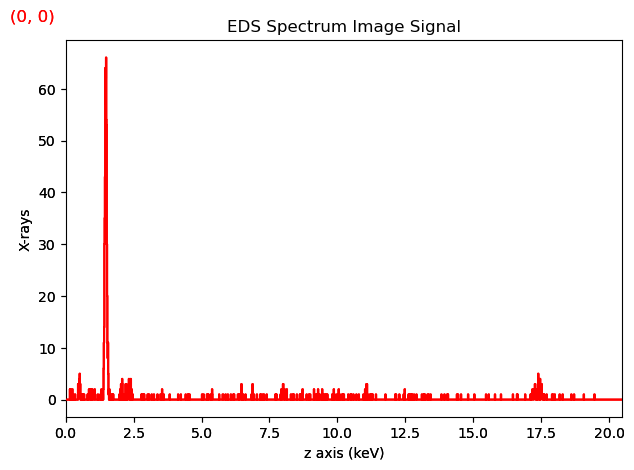

In [5]:
bins = (6,6,1) # x, y, signal

sb = s.rebin(scale = bins)
sb.add_elements(elements)
sb.plot()

Inspect the transposed signal.

In [ ]:
sb.T.plot()

## 3.1 Crop signal
Check element X-ray ranges:

In [29]:
# Get hyperspy material elements as dictionary
try: from exspy.misc.elements import elements as mat_dict
except ModuleError: mat_dict = elements.as_dictionary()

maxE = ['',0] # Element, energy
for e in s.metadata.Sample.xray_lines:
    elem, line = e.split('_')
    energy = mat_dict[elem]['Atomic_properties']['Xray_lines'][line]['energy (keV)']
    if maxE[-1] < energy: 
        maxE[-1] = energy
        maxE[0] = elem
    print(elem + ':', energy, 'keV')
print('\nMaximum energy:', maxE, 'keV')

Al: 1.4865 keV
Ar: 2.9577 keV
C: 0.2774 keV
Cr: 5.4147 keV
Cu: 8.0478 keV
Fe: 6.4039 keV
Ga: 9.2517 keV
Mg: 1.2536 keV
Mn: 5.8987 keV
O: 0.5249 keV
Si: 1.7397 keV
Ti: 4.5109 keV
Zr: 15.7753 keV

Maximum energy: ['Zr', 15.7753] keV


Crop signal.

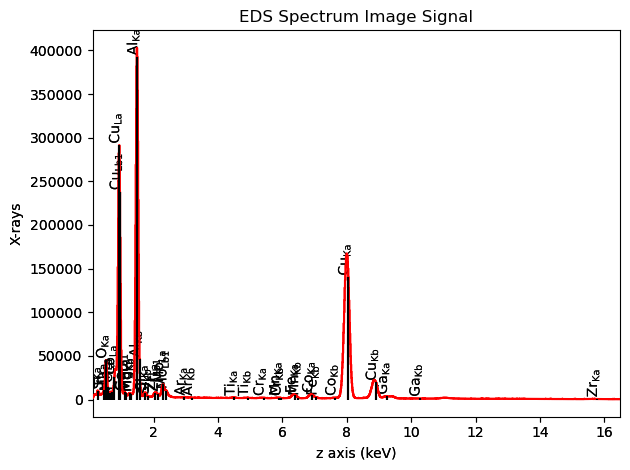

In [6]:
sig_range = (0.1, 16.5)

sbc = sb.isig[sig_range[0]:sig_range[-1]]
sbc.sum().plot(xray_lines = 'from_elements')

Check signal type (we want it to be EDSTEMSpectrum):

In [ ]:
sbc

In [ ]:
sbc.metadata

Save signal:

In [ ]:
sbc.save(path + 'sbc.hspy')

# <a id='four'><a> 4. Model fitting and element quantification
We want to fit a model to out signal prior to element quantification. We will also use it for signal clustering.

In [7]:
s = sbc

Check signal Sample metadata:

In [ ]:
s.metadata.Sample.elements

In [ ]:
s.metadata.Sample.xray_lines

## 4.1 Create initial model

In [ ]:
m = s.create_model(auto_background=False)

In [ ]:
m.plot()

Define a polynomial background:

In [ ]:
m.add_polynomial_background(order = 10) 

In [ ]:
m.plot()

Print model components and values:

In [ ]:
m.components

In [ ]:
m.print_current_values()

Fit the background:

In [ ]:
m.fit(bounded = True)
m.fit_background()
m.calibrate_energy_axis(calibrate='scale')
m.calibrate_energy_axis(calibrate='offset')

In [ ]:
m.plot()

## 4.2 Perform multifitting

In [ ]:
m.multifit(iterpath = 'serpentine', show_progressbar=True)

Check model:

In [ ]:
m.plot()

Define the sum spectrum and check if the model needs calibration.

In [ ]:
s_sum = s.sum()
s_sum.plot(xray_lines = 'from_elements')

Re-fit backgruond.

In [ ]:
m.fit_background()
m.fit(bounded = True)

Check model:

In [ ]:
m.plot()

Save the model.

In [ ]:
m.save(path + 'm.hspy')

Make the model into a signal. We will use this for signal clustering, as cluster analysis can be sensitive to intensities.

In [ ]:
#ms = m.as_signal().data
try: ms.metadata = s.metadata
except AttributeError:
    for key in s.metadata.keys(): ms.metadata[key] = s.metadata[key]
ms.axes_manager = m.axes_manager

Check the difference between the summed model and signal:

In [ ]:
plt.figure()
plt.plot(ms.sum(), label = 'model')
plt.plot(s.sum(), label = 'raw')
plt.legend()

Save model as signal:

In [ ]:
ms.save(path + 'ms.hspy')

## 4.3 Element quantification
Define k-factors for Cliff-Lorimer quantification:

In [10]:
k_factors = dict()

k_factors['Al_Ka'] = 1.040
k_factors['Ar_Ka'] = 2.957
k_factors['C_Ka'] = 4.283
k_factors['Cr_Ka'] = 1.427 
k_factors['Cu_Ka'] = 2.023 
k_factors['Fe_Ka'] = 1.585 
k_factors['Fe_La'] = 6.021 
k_factors['Ga_Ka'] = 2.419 
k_factors['Ga_La'] = 4.719 
k_factors['Mg_Ka'] = 1.054 
k_factors['Mn_Ka'] = 1.526 
k_factors['O_Ka'] = 1.815 
k_factors['Si_Ka'] = 1.000
k_factors['Ti_Ka'] = 1.321 
k_factors['Zr_Ka'] = 6.94 
k_factors['Zr_La'] = 3.901

Set relevant k-factors:

In [14]:
line_list = np.array(s.metadata.Sample.xray_lines)
kfactors = [k_factors[line] for line in line_list]

Get model intensities:

In [18]:
m_intensities = m.get_lines_intensity(xray_lines=s.metadata.Sample.xray_lines)

Perform element quantification using the Cliff-Lorimer approach:

In [19]:
q = s.quantification(m_intensities, method='CL', factors=kfactors, 
                                        plot_result=False, composition_units='atomic', 
                                        absorption_correction = False)

[########################################] | 100% Completed | 101.38 ms


### 4.3.1 Plot quantified element maps
Plot quantified element maps:

[<Axes: title={'center': 'Al'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Ar'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'C'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Cr'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Cu'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Fe'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Ga'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Mg'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Mn'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'O'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Si'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Ti'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Zr'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>]

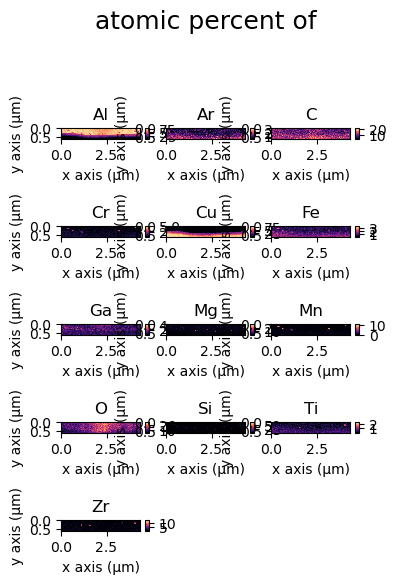

In [20]:
hs.plot.plot_images(q, cmap = 'magma')

Define a dictionary containing the element-specific indices:

In [21]:
qlib = dict()
for i in s.metadata.Sample.elements:
    if np.where(line_list == i + '_La')[0]: qlib[i] = np.where(line_list == i + '_La')[0].tolist()[0]
    else: qlib[i] = np.where(line_list == i + '_Ka')[0].tolist()[0]

/tmp/ipykernel_841384/3154175358.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.where(line_list == i + '_La')[0]: qlib[i] = np.where(line_list == i + '_La')[0].tolist()[0]


Plot specific element maps:

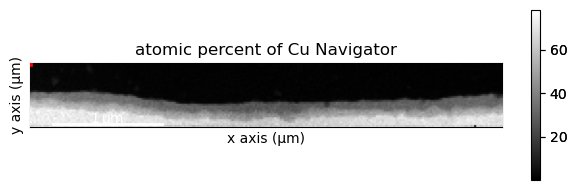

In [22]:
elem = 'Cu'
q[qlib[elem]].plot()

Plot all element maps:

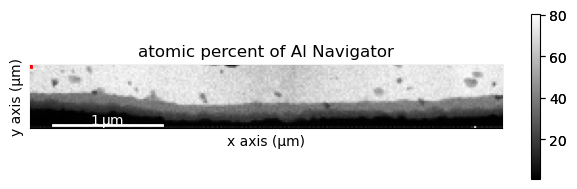

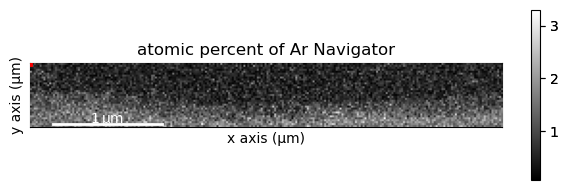

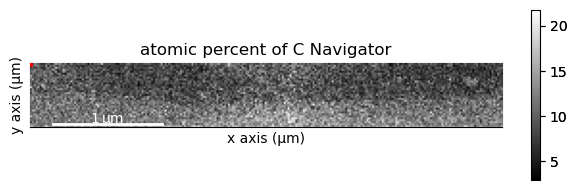

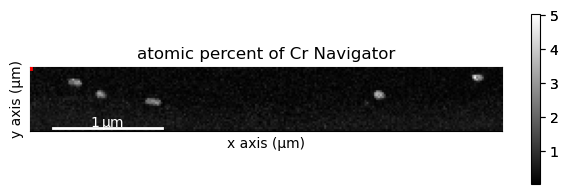

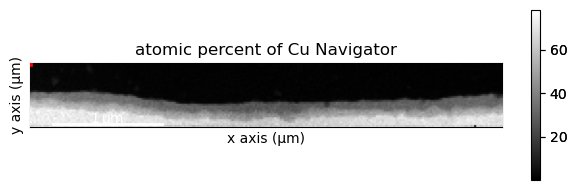

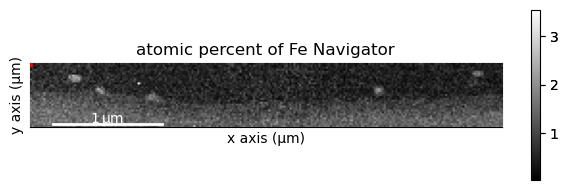

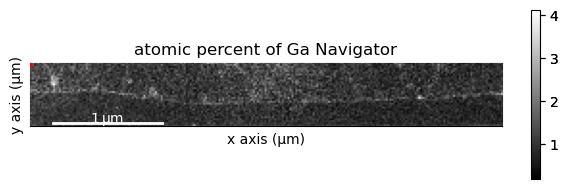

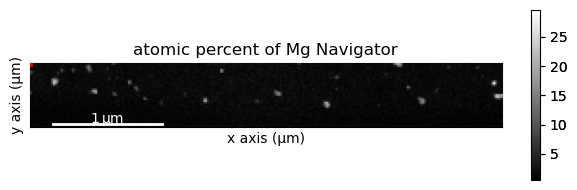

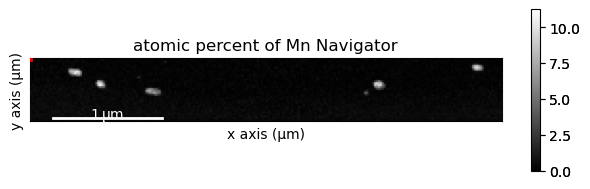

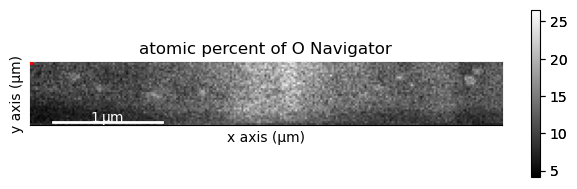

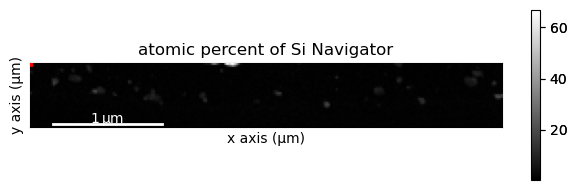

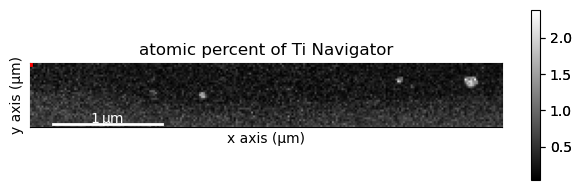

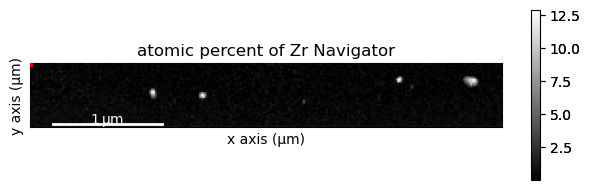

In [23]:
for arg in qlib.keys(): q[qlib[arg]].plot()

Check line profiles:

In [24]:
EOI = ['Al','Cu'] # Define element maps to inspect

Define a line ROI:

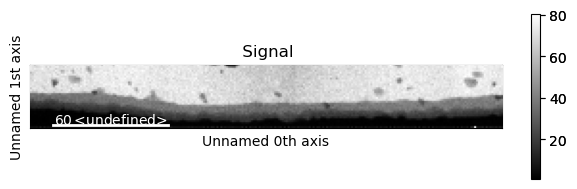

In [25]:
roi = hs.roi.Line2DROI(x1 = 120, y1 = 0, x2 = 120, y2 = 32, linewidth = 3)
eoi = hs.signals.BaseSignal(q[qlib[EOI[0]]])
eoi.plot()

Get and plot lines:

<Axes: xlabel='<undefined> (<undefined>)', ylabel='Intensity'>

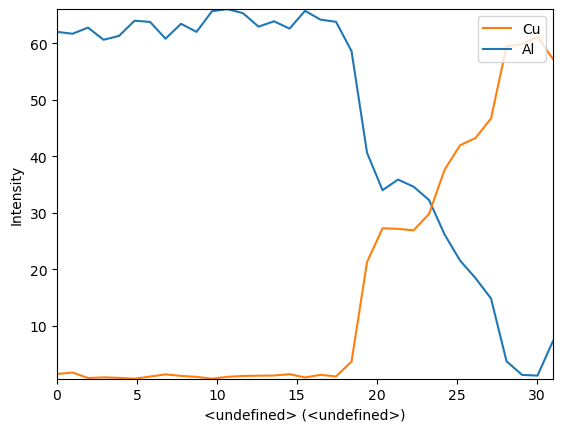

In [26]:
lines = []
for i in range(len(EOI)):
    eoi = hs.signals.BaseSignal(q[qlib[EOI[i]]])
    eoi.plot()
    lines.append(roi.interactive(eoi))
    plt.close('all')

hs.plot.plot_spectra(lines, legend = EOI)

# <a id='five'><a>5 spactra clustering
It's important to be aware that signals outght to be similar prior to clustering. Otherwise we might get strange results. Spectrum intensities should therefore be normalized. 

We could've used environment elements such as signals from the Mo grid. However, as Al and Cu are the major elements and Al is not capable of exciting Mo, we will use the at.\% ratios between Al and Cu to normalize the model: 

\begin{align}
\text{ratio}_{ij} = \frac{[\text{elem.1}]_{ij}}{([\text{elem.1}]_{ij} + [\text{elem.2}]_{ij})}.
\end{align}

Specifically, we will use the peak value for either $\text{Al}_{K\alpha}$ or $\text{Cu}_{K\alpha}$ as defined by a threshold ratio. I.e. the threshold tells ut when to use the former or the latter.

## 5.1 Spectra normalization
Specify elements of interest (EOI) to cluster and define the element ratio map.

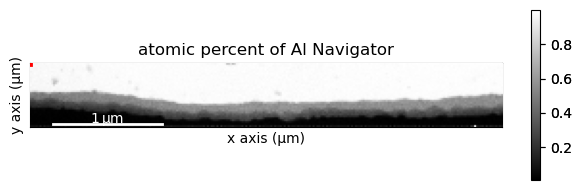

In [27]:
EOI = ['Al', 'Cu']

ratio_map = q[qlib[EOI[0]]] / (q[qlib[EOI[0]]] + q[qlib[EOI[1]]])
ratio_map.plot()

Specify $K\alpha$ line ranges (keV):

In [30]:
width = 0.1

E_vals = {EOI[0] : np.asarray([mat_dict[EOI[0]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - width,
                              mat_dict[EOI[0]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] + width]), 
          EOI[1] : np.asarray([mat_dict[EOI[1]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - width,
                              mat_dict[EOI[1]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] + width])} 

Define the ratio map threshold and normalize the model:

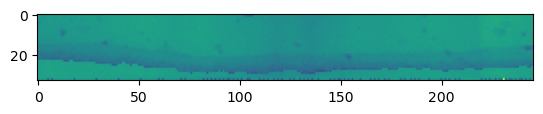

In [31]:
ratio_thresh = 0.1

# Get shapes
(X, Y), E_scale = m.axes_manager.navigation_shape[::-1], m.axes_manager[-1].scale

# Define intensity scale map
SI_scale = np.ndarray((X,Y))

# Find max intensity for EOI1s Ka and store the value
si_temp = ms.isig[E_vals[EOI[0]][0]:E_vals[EOI[0]][1]]
scale_roi = np.where(ratio_map.data > ratio_thresh)
SI_scale[scale_roi] = si_temp.max(-1).data[scale_roi]

# Same as above for EOI2
si_temp = ms.isig[E_vals[EOI[1]][0]:E_vals[EOI[1]][1]]
scale_roi = np.where(ratio_map.data < ratio_thresh)
SI_scale[scale_roi] = si_temp.max(-1).data[scale_roi]

plt.figure()
plt.imshow(np.log(SI_scale))
plt.show()

Normalize signal model:

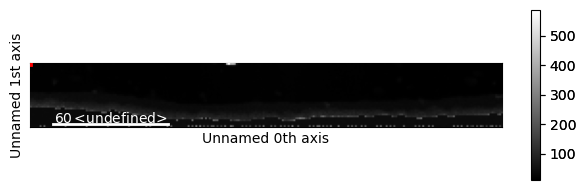

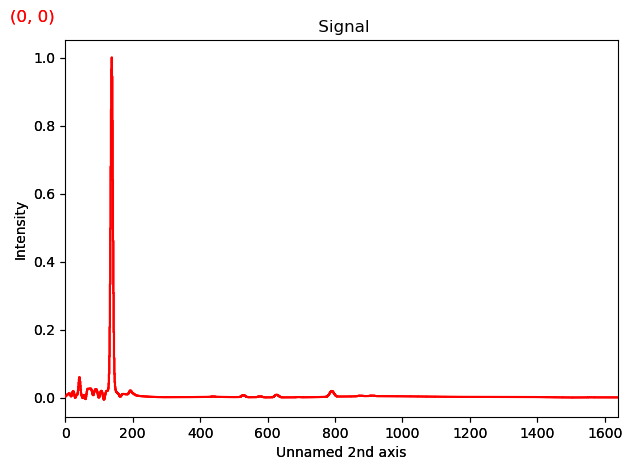

In [32]:
ms_scaled = hs.signals.Signal1D(np.divide(ms.deepcopy().data, np.reshape(SI_scale, SI_scale.shape + (1,)))) 
ms_scaled.plot()

Save signal:

In [ ]:
ms.save(path + 'ms_scaled.hspy')

## 5.2 Spectra clustering
Cluster analysis compares and groups signals that lie closest together. Different algorithms exists with different clustering properties (see scikit-learn). Here, the simple k-means algorithm will be employed. As initialization is important, k-means++ will be used. It initializes centroids to be (generally) distant from one another. 

Estimate number of clusters:

In [34]:
best_k = ms_scaled.estimate_number_of_clusters(cluster_source="signal", metric="silhouette")

  0%|          | 0/9 [00:00<?, ?it/s]

<Axes: xlabel='number of clusters', ylabel='silhouette_metric'>

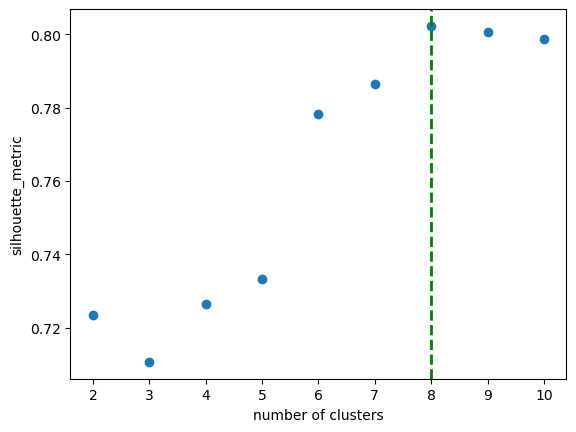

In [35]:
ms_scaled.plot_cluster_metric()

We see that 8 cluster centers are suggested, but we are only interested in four. 

Unfold the model signal prior to clustering to avoid any chance of influence from how it's shape. Perform signal clustering:

In [50]:
from sklearn.cluster import KMeans, kmeans_plusplus

n_clusters = 4

c = ms.deepcopy()
c.unfold() # To avoid any influence from navigation shape
c_info = c.cluster_analysis(cluster_source = "signal", n_clusters = n_clusters, preprocessing = "norm", 
                                algorithm = KMeans(n_clusters = n_clusters, init = 'k-means++', 
                                max_iter = 100000), 
                                return_info = True)
ls = c.get_cluster_labels()
signals = c.get_cluster_signals()
c.fold()

# Reshape results:
labels = np.zeros((n_clusters,) + c.axes_manager.navigation_shape[::-1])
for i in range(n_clusters):
    labels[i] = np.reshape(ls.data[i], c.axes_manager.navigation_shape[::-1]).copy()
labels = hs.signals.Signal2D(labels)

Plot results

WARNING | Hyperspy | Axes labels were requested, but one or both of the axes units and/or name are undefined. Axes decorations have been set to 'ticks' instead. (hyperspy.drawing.utils:1166)


[<Axes: title={'center': ' (0,)'}>,
 <Axes: title={'center': ' (1,)'}>,
 <Axes: title={'center': ' (2,)'}>,
 <Axes: title={'center': ' (3,)'}>]

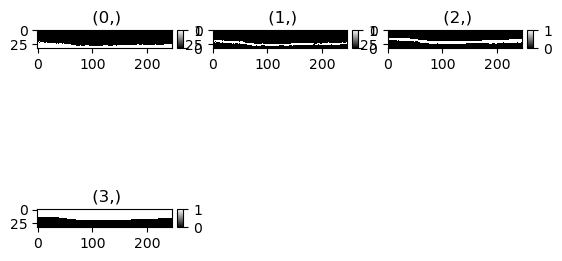

In [51]:
hs.plot.plot_images(labels)

<Axes: xlabel='z (keV)', ylabel='Intensity'>

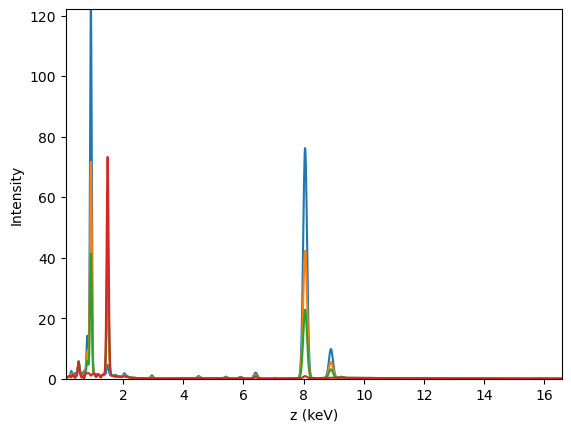

In [52]:
hs.plot.plot_spectra(signals)

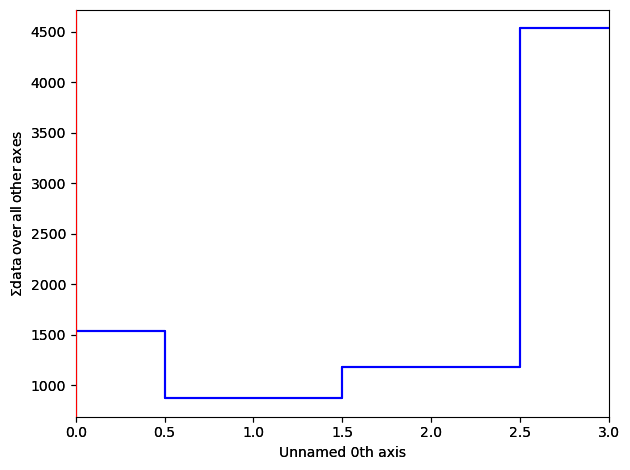

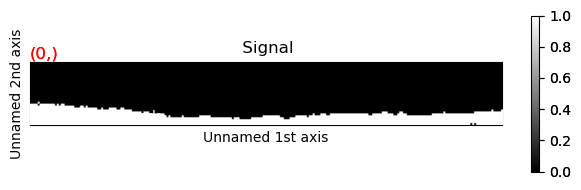

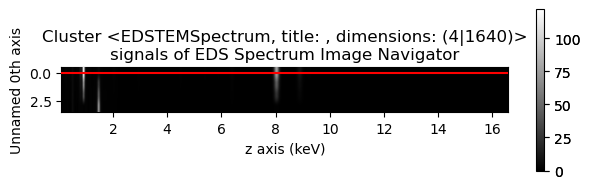

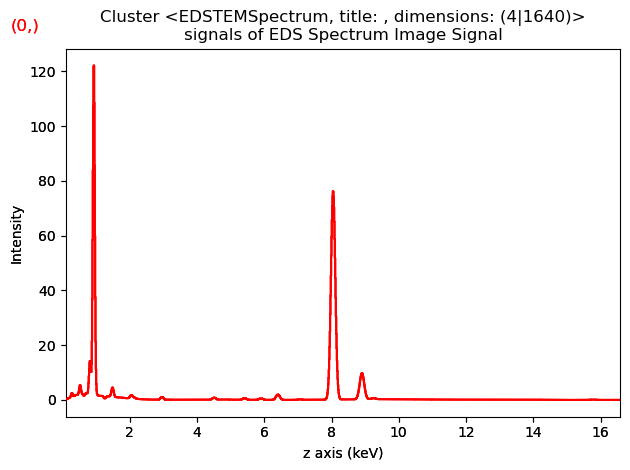

In [53]:
hs.plot.plot_signals([labels, signals])

It should be stressed that it's important to run the clustering several times to ensure consistent results. Due to initialization, some pixels might be labelled differently between each run. If many pixels are labelled differently, a different normalization routine should be used. It might also happen that clustering is not suitable. Here, little difference should take place between each run.

Save results

In [ ]:
c.learning_results.save(path + 'learning_results')

## 5.2 Get segmented spectra
Remove outliers

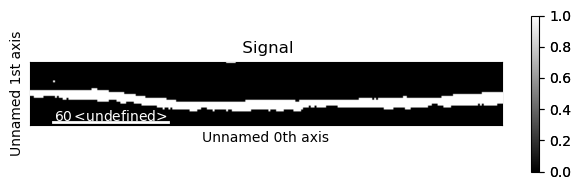

In [61]:
labels.inav[2].plot()

In [62]:
# Identify the labels
label_ids = [1,2] 
min_size = 6 # Remove small pixels that are not of interest

from skimage.morphology import remove_small_objects as rso
nav_masks = np.asarray([rso(labels.data[i].astype(bool), min_size = min_size) for i in label_ids])

Save masks

In [ ]:
np.save(path + 'intermetallic_layers', nav_masks)

## 5.3 Get spectra from defined IMP layers

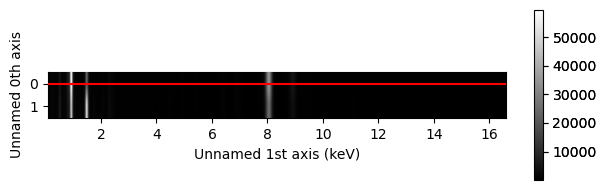

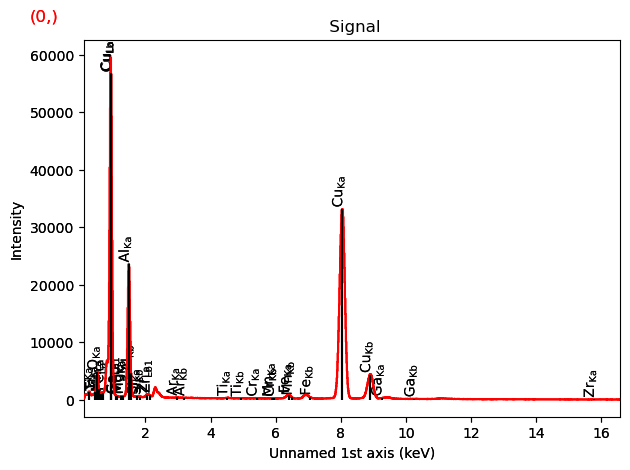

In [67]:
import exspy
IMP_spectra = exspy.signals.EDSTEMSpectrum([np.sum(s.data[np.where(nav_masks[i])], axis = 0) for i in range(len(nav_masks))])

IMP_spectra.axes_manager[-1].scale = m.axes_manager[-1].scale
IMP_spectra.axes_manager[-1].offset = m.axes_manager[-1].offset
IMP_spectra.axes_manager[-1].units = m.axes_manager[-1].units

IMP_spectra.set_elements(elements)
IMP_spectra.add_lines()
IMP_spectra.plot(xray_lines = 'from_elements')

#### Plot with labels

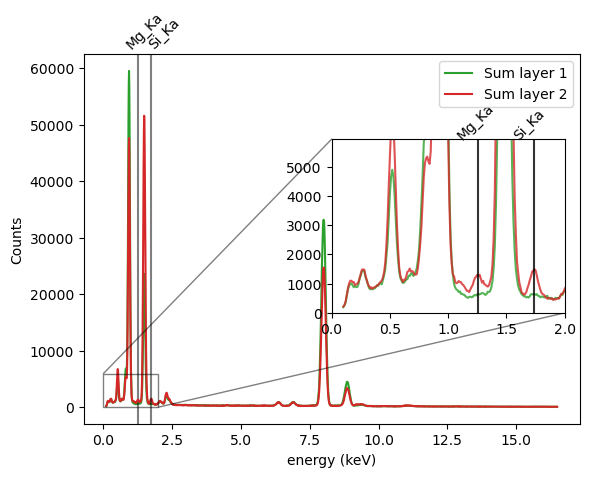

In [146]:
fig, ax = plt.subplots()

sig_shape = s.axes_manager.signal_extent
sig_scale = s.axes_manager[-1].scale
xrange = np.linspace(sig_shape[0], sig_shape[1], s.axes_manager[-1].size)

ax.plot(xrange, IMP_spectra.data[0], c = 'tab:green', label = 'Sum layer 1')

# Annotate Mg_Ka:
ax.axvline(x = mat_dict['Mg']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'], 
              ymin = 0, ymax=1, c = 'k', alpha = 0.5)
ax.text(x = mat_dict['Mg']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - 0.5, 
              y = np.max(IMP_spectra.data + 4e3), s = 'Mg_Ka', rotation = 45)
ax.plot(xrange, IMP_spectra.data[1], c = 'tab:red', label = 'Sum layer 2')

# Annotate Si_Ka:
ax.axvline(x = mat_dict['Si']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'], 
              ymin = 0, ymax=1, c = 'k', alpha = 0.5)
ax.text(x = mat_dict['Si']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - 0.2, 
              y = np.max(IMP_spectra.data + 4e3), s = 'Si_Ka', rotation = 45)
# Set labels
ax.set_xlabel('energy (keV)')
ax.set_ylabel('Counts')
ax.legend()





# Inset ranges:
x1, x2, y1, y2 = 0, 2.0, 0, np.max(IMP_spectra.data) / 10 

# Inset's relative position:
axins = ax.inset_axes(
    [0.5, 0.3, 0.47, 0.47], # [x, y, width, height] w.r.t. ax
    xlim=(x1, x2), ylim=(y1, y2))

# Plot zoomed-in data:
axins.plot(xrange[int(x1/sig_scale):int(x2/sig_scale)], 
           IMP_spectra.data[0, int(x1/sig_scale):int(x2/sig_scale)], c = 'tab:green',
          alpha = 0.8)
axins.plot(xrange[int(x1/sig_scale):int(x2/sig_scale)], 
           IMP_spectra.data[1, int(x1/sig_scale):int(x2/sig_scale)], c = 'tab:red',
          alpha = 0.8)

# Put on horizontal lines:
axins.axvline(x = mat_dict['Mg']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'], 
              ymin = 0, ymax=1, c = 'k', alpha = 0.8)
axins.text(x = mat_dict['Mg']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - 0.2, 
              y = y2, s = 'Mg_Ka', rotation = 45)
axins.axvline(x = mat_dict['Si']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'], 
              ymin = 0, ymax=1, c = 'k', alpha = 0.8)
axins.text(x = mat_dict['Si']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - 0.2, 
              y = y2, s = 'Si_Ka', rotation = 45)

# Indicate inset:
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

Plot RGB image of the labele

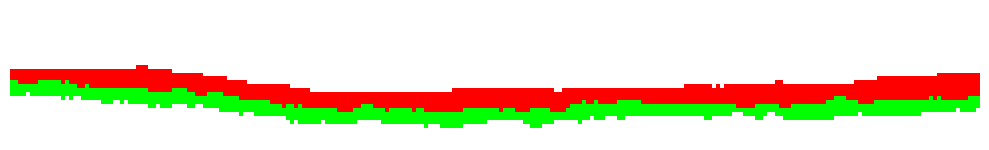

In [141]:
from matplotlib.colors import ListedColormap

N = 256 # RGB values
vals = np.ones((N, 4)) 
alf = 1.0 

#quant_maps_scaled = (quant_maps_scaled-np.min(quant_maps_scaled))/(np.max(quant_maps_scaled)-np.min(quant_maps_scaled))*N

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), sharex=True, sharey=True)

a = (0,1,0) # R
vals[:, 0] = np.linspace(1, a[0], N) #(start, stop, num = N)
vals[:, 1] = np.linspace(1, a[1], N)
vals[:, 2] = np.linspace(1, a[2], N)
vals[:, 3] = np.linspace(0, alf, N)
cmap1 = ListedColormap(vals.copy()) # Colormap object generated from a list of 
# colors.
im = ax1.imshow(nav_masks[0], cmap=cmap1, interpolation='nearest')

a = (1,0,0) # G
vals[:, 0] = np.linspace(1, a[0], N) 
vals[:, 1] = np.linspace(1, a[1], N)
vals[:, 2] = np.linspace(1, a[2], N)
vals[:, 3] = np.linspace(0, alf, N)
cmap2 = ListedColormap(vals.copy())

im = ax1.imshow(nav_masks[1], cmap=cmap2, interpolation='nearest')

ax1.axis('off')
fig.tight_layout()
plt.show()